In [1]:
%matplotlib inline
import networkx as nx
#import pygraphviz
import pyparsing
import numpy as np
import matplotlib.pylab as plt

from IPython.display import Math

In [124]:
# An implementation of the forward backward algorithm
# For numerical stability, we calculate everything in the log domain

def normalize_exp(log_P, axis=None):
    a = np.max(log_P, keepdims=True, axis=axis)
    P = normalize(np.exp(log_P - a), axis=axis)
    return P


def normalize(A, axis=None):
    Z = np.sum(A, axis=axis,keepdims=True)
    idx = np.where(Z == 0)
    Z[idx] = 1
    return A/Z

def randgen(pr, N=1): 
    L = len(pr)
    return np.random.choice(range(L), size=N, replace=True, p=pr)

def predict(A, lp):
    lstar = np.max(lp)
    return lstar + np.log(np.dot(A,np.exp(lp-lstar)))

def postdict(A, lp):
    lstar = np.max(lp)
    return lstar + np.log(np.dot(np.exp(lp-lstar), A))

def update(y, logB, lp):
    return logB[y,:] + lp

# Generate Parameter
S = 7
R = 2
A = np.random.dirichlet(0.7*np.ones(S),S).T
B = np.random.dirichlet(0.7*np.ones(R),S).T
p = np.random.dirichlet(0.7*np.ones(S)).T

logA = np.log(A)
logB = np.log(B)

In [125]:
print (A)

[[ 0.20803966  0.00171297  0.01767966  0.01396564  0.84065231  0.00739805
   0.33978663]
 [ 0.00118965  0.02536291  0.09106425  0.28817514  0.04536952  0.00416653
   0.0088411 ]
 [ 0.01385449  0.5317387   0.07727573  0.0202794   0.02676278  0.31324128
   0.00277233]
 [ 0.22694357  0.04969807  0.04754057  0.30724844  0.00596977  0.03113069
   0.15629859]
 [ 0.20928937  0.04528827  0.32613882  0.21840687  0.00100378  0.20360211
   0.40526958]
 [ 0.1234479   0.10220031  0.18216326  0.07806302  0.03176438  0.31738165
   0.00877875]
 [ 0.21723537  0.24399877  0.25813771  0.07386148  0.04847747  0.12307967
   0.07825302]]


In [126]:
print (B)

[[ 0.00671209  0.75378593  0.91671497  0.79477842  0.14397868  0.54348066
   0.98683853]
 [ 0.99328791  0.24621407  0.08328503  0.20522158  0.85602132  0.45651934
   0.01316147]]


In [127]:
print (p)

[ 0.07013134  0.51743902  0.02434814  0.27422699  0.04422496  0.04275994
  0.02686961]


In [128]:
# Generate Data

# Number of steps
T = 50

x = np.zeros(T,int)
y = np.zeros(T,int)
for t in range(T):
    if t==0:
        x[t] = randgen(p)
    else:
        x[t] = randgen(A[:,x[t-1]])
    
    y[t] = randgen(B[:,x[t]])

In [129]:
print (x)

[1 2 5 4 6 0 0 6 4 0 5 2 4 6 0 3 5 6 0 4 0 3 1 2 4 0 3 6 4 0 0 4 5 5 5 2 6
 0 3 3 6 4 2 5 2 1 6 3 6 3]


In [130]:
print (y)

[1 0 1 0 0 1 1 0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0
 1 0 0 0 1 0 1 1 0 0 0 0 0]


In [131]:
log_alpha  = np.zeros((S, T))
log_alpha_pred = np.zeros((S, T))

for k in range(T):
    if k==0:
        log_alpha_pred[:,0] = np.log(p)
    else:
        log_alpha_pred[:,k] = predict(A, log_alpha[:,k-1])
    
    log_alpha[:,k] = update(y[k], logB, log_alpha_pred[:,k])
    
print ("log alpha: ")
print (log_alpha)
print ("log alpha pred: ")
print (log_alpha_pred)


log alpha: 
[[ -2.66412019  -8.0483105   -3.6972191   -8.07702907 -10.28014336
   -5.8939416   -5.6178889  -11.54712322  -7.74344188  -7.46485073
   -8.42557687 -13.81890275 -15.41080965 -16.21832122 -11.88717069
  -16.52093803 -13.56634773 -13.17331615 -14.15146779 -14.5378855
  -15.19984794 -20.74080371 -22.22562237 -23.06236348 -18.74099466
  -18.37020348 -24.32068235 -25.49672795 -21.42324667 -21.18052539
  -22.0795598  -22.50465412 -23.15070442 -23.70173427 -29.29172626
  -30.74069023 -31.58702344 -27.26882538 -31.89259148 -33.93782963
  -34.58833395 -30.29474033 -34.96620724 -31.99867825 -31.6106212
  -37.58509275 -38.74435476 -39.67362569 -40.37076781 -40.89576877]
 [ -2.0604175   -4.12148708  -5.48137497  -5.82530334  -6.18863893
   -7.91710854  -9.44078588  -9.50667932  -9.72011678 -11.24610597
  -12.49366542 -11.40927986 -11.24538552 -11.95072394 -13.81036172
  -14.21883376 -15.5799255  -16.99850329 -18.26864258 -18.24230318
  -19.04808679 -18.40329457 -18.06815701 -18.783480

In [132]:
# An implementation of the forward backward algorithm
# Backward Pass
log_beta  = np.zeros((S, T))
log_beta_post = np.zeros((S, T))

for k in range(T-1,-1,-1):
    if k==T-1:
        log_beta_post[:,k] = np.zeros(S)
    else:
        log_beta_post[:,k] = postdict(A, log_beta[:,k+1])
    
    log_beta[:,k] = update(y[k], logB, log_beta_post[:,k])
    
print ("log_beta: ")
print (log_beta)
print ("log_beta_post: ")
print (log_beta_post)  
    

log_beta: 
[[ -3.36098127e+01  -3.79942870e+01  -3.22452833e+01  -3.61835482e+01
   -3.56835225e+01  -3.03756252e+01  -2.93246091e+01  -3.37550294e+01
   -2.81120700e+01  -2.76888481e+01  -2.68513337e+01  -3.12097682e+01
   -3.02650758e+01  -2.96535463e+01  -2.36067774e+01  -2.80519016e+01
   -2.24617078e+01  -2.19108516e+01  -2.12634772e+01  -2.08435259e+01
   -1.99967858e+01  -2.44702999e+01  -2.34239960e+01  -2.28943808e+01
   -1.74570024e+01  -1.66919576e+01  -2.06481334e+01  -2.01011776e+01
   -1.45294232e+01  -1.39363331e+01  -1.33854966e+01  -1.27381101e+01
   -1.23184078e+01  -1.14721932e+01  -1.58344435e+01  -1.48874535e+01
   -1.42490660e+01  -8.41400275e+00  -1.27722531e+01  -1.18284592e+01
   -1.12205057e+01  -5.17432547e+00  -9.66000865e+00  -4.27379913e+00
   -3.35221978e+00  -7.68866068e+00  -7.07552676e+00  -6.48254323e+00
   -5.68315979e+00  -5.00384563e+00]
 [ -3.46742045e+01  -3.41467383e+01  -3.28050543e+01  -3.09402934e+01
   -3.23993856e+01  -3.27340363e+01  -3.02

In [133]:
import numpy as np

def log_sum_exp_naive(l):
    return np.log(np.sum(np.exp(l)))

def log_sum_exp(l, axis=0):
    l_star = np.max(l, axis=axis, keepdims=True)
    return l_star + np.log(np.sum(np.exp(l - l_star),axis=axis,keepdims=True)) 


log_gamma = log_alpha + log_beta_post
print(log_sum_exp(log_gamma))

[[-34.70765629 -34.70765629 -34.70765629 -34.70765629 -34.70765629
  -34.70765629 -34.70765629 -34.70765629 -34.70765629 -34.70765629
  -34.70765629 -34.70765629 -34.70765629 -34.70765629 -34.70765629
  -34.70765629 -34.70765629 -34.70765629 -34.70765629 -34.70765629
  -34.70765629 -34.70765629 -34.70765629 -34.70765629 -34.70765629
  -34.70765629 -34.70765629 -34.70765629 -34.70765629 -34.70765629
  -34.70765629 -34.70765629 -34.70765629 -34.70765629 -34.70765629
  -34.70765629 -34.70765629 -34.70765629 -34.70765629 -34.70765629
  -34.70765629 -34.70765629 -34.70765629 -34.70765629 -34.70765629
  -34.70765629 -34.70765629 -34.70765629 -34.70765629 -34.70765629]]


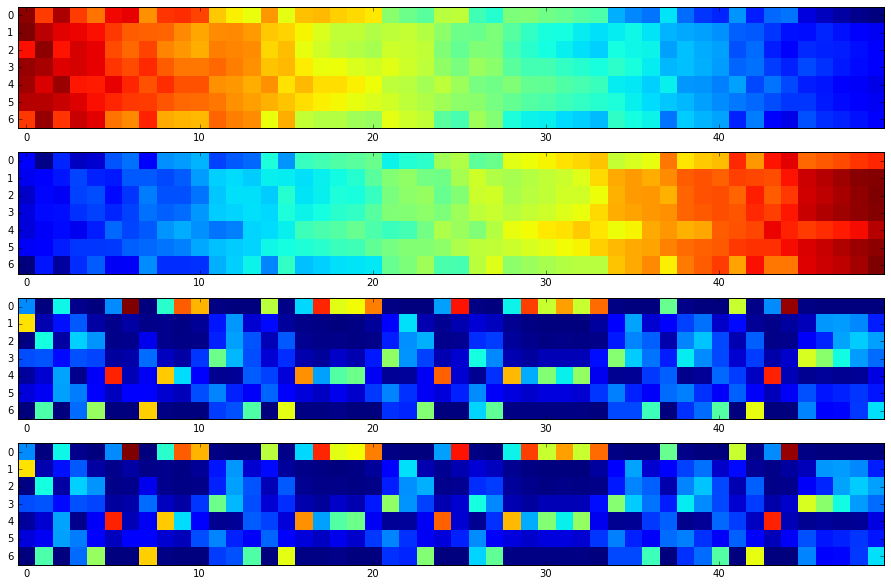

In [134]:
# Correction Smoother
# For numerical stability, we calculate everything in the log domain
log_gamma_corr = np.zeros_like(log_alpha)
log_gamma_corr[:,T-1] = log_alpha[:,T-1]

for k in range(T-2,-1,-1):
    log_old_pairwise_marginal = log_alpha[:,k].reshape(1,S) + logA 
    log_old_marginal = predict(A, log_alpha[:,k])
    log_new_pairwise_marginal = log_old_pairwise_marginal + log_gamma_corr[:,k+1].reshape(S,1) - log_old_marginal.reshape(S,1)
    log_gamma_corr[:,k] = log_sum_exp(log_new_pairwise_marginal, axis=0).reshape(S)
    

# Verify that result coincide

gam = normalize_exp(log_gamma, axis=0)
gam_corr = normalize_exp(log_gamma_corr, axis=0)





plt.figure(figsize=(20,10))
plt.subplot(4,1,1)
plt.imshow(log_alpha, interpolation='nearest')
plt.subplot(4,1,2)
plt.imshow(log_beta, interpolation='nearest')
plt.subplot(4,1,3)
plt.imshow(gam, interpolation='nearest')
plt.subplot(4,1,4)
plt.imshow(gam_corr, interpolation='nearest')

plt.show()